In [1]:
from langchain.tools.retriever import create_retriever_tool
from langchain_core.documents import Document
from langchain_core.messages import SystemMessage
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_redis import RedisVectorStore
from langgraph.graph import START, MessagesState, StateGraph
from langgraph.prebuilt import (
    tools_condition,  # this is the checker for the if you got a tool back
)
from langgraph.prebuilt import ToolNode

In [2]:
SYS_MSG = SystemMessage(
    content="You are an oregon trail playing AI agent. Use the tools available to answer the questions provided. Important: if options are provided in the question replay only with the single character A, B, C, or D and no additional text."
)


In [4]:
from dotenv import load_dotenv

load_dotenv()

True

In [5]:
doc = Document(
    page_content="the northern trail, of the blue mountains, was destroyed by a flood and is no longer safe to traverse. It is recommended to take the southern trail although it is longer."
)

vectorstore = RedisVectorStore.from_documents(
    [doc],
    OpenAIEmbeddings(),
    redis_url="redis://localhost:6379/0",
    index_name="oregon_trail",
)

retriever_tool = create_retriever_tool(
    vectorstore.as_retriever(),
    "retrieve_trail_tips",
    "Search and return information that is helpful for answering questions about what to do next on the Oregon Trail",
)

tools = [retriever_tool]

In [43]:
from langchain_redis import RedisConfig

config = RedisConfig(index_name="oregon_trail", redis_url="redis://localhost:6379/0")

def get_vectorstore(config):
    try:
        config.from_existing = True
        vectorstore = RedisVectorStore(OpenAIEmbeddings(), config=config)
    except:
        print("Init vector store")
        config.from_existing = False
        vectorstore = RedisVectorStore.from_documents(
            [doc],
            OpenAIEmbeddings(),
            config=config
        )
    return vectorstore


In [45]:
vs = get_vectorstore(config)

10:36:02 redisvl.index.index INFO   Index already exists, not overwriting.


In [22]:
vectorstore = RedisVectorStore.from_documents(
    [doc],
    OpenAIEmbeddings(),
    redis_url=config.redis_url,
    index_name=config.index_name,
)

In [31]:
config = RedisConfig(index_name="oregon_trail", redis_url="redis://localhost:6379/0")
vectorstore = RedisVectorStore.from_documents(
    [doc],
    OpenAIEmbeddings(),
    config=config
)

In [20]:
vs = get_vectorstore(config)

Init vector store


In [11]:
existing_vector_store.index.info()["num_docs"]

1

In [29]:
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)


In [ ]:
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

def agent(state: MessagesState):
    print(state["messages"])
    if state['messages'][-1].name == "retrieve_blog_posts":
        return {
            "messages": [
                llm_with_tools.invoke(
                    [SYS_MSG] + 
                    [f"{state['messages'][0].content} \
                     consider context: {state['messages'][-1].content}"]
                    )
                ]
            }
    else:
        return {"messages": [llm_with_tools.invoke([SYS_MSG] + state['messages'])]}

builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("agent", agent)
builder.add_node("tools", ToolNode(tools))  # for the tools

# Add edges
builder.add_edge(START, "agent")
builder.add_conditional_edges(
    "agent",
    # If the latest message (result)
    # from node agent is a tool call -> tools_condition routes to tools
    # If the latest message (result)
    # from node agent is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "agent")
graph = builder.compile()

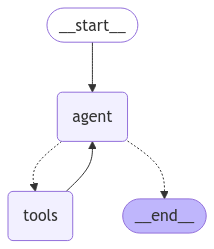

In [7]:
from IPython.display import Image, display

builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("agent", agent)
builder.add_node("tools", ToolNode(tools))  # for the tools

# Add edges
builder.add_edge(START, "agent")
builder.add_conditional_edges(
    "agent",
    # If the latest message (result)
    # from node agent is a tool call -> tools_condition routes to tools
    # If the latest message (result)
    # from node agent is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "agent")
graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [57]:
from langchain_core.messages import HumanMessage

def format_question(q):
    question = q["question"]
    options = q.get("options", "")
    if options:
        formatted = f"{question}, options: {' '.join(options)}"
    else:
        formatted = question
    
    print(formatted)
    return [HumanMessage(content=formatted)]

In [58]:
import json

with open("questions.json") as f:
    questions = json.load(f)

res = graph.invoke({"messages": format_question(questions[0])})

You’ve encountered a dense forest near the Blue Mountains, and your party is unsure how to proceed. There is a fork in the road, and you must choose a path. Which way will you go?, options: A: take the northern trail B: take the southern trail C: turn around D: go fishing
[HumanMessage(content='You’ve encountered a dense forest near the Blue Mountains, and your party is unsure how to proceed. There is a fork in the road, and you must choose a path. Which way will you go?, options: A: take the northern trail B: take the southern trail C: turn around D: go fishing', additional_kwargs={}, response_metadata={}, id='3f3718e1-a532-449a-aa29-7ac389a270ed')]
[HumanMessage(content='You’ve encountered a dense forest near the Blue Mountains, and your party is unsure how to proceed. There is a fork in the road, and you must choose a path. Which way will you go?, options: A: take the northern trail B: take the southern trail C: turn around D: go fishing', additional_kwargs={}, response_metadata={},

In [59]:
res['messages'][-1].content

'B'

In [36]:
res

{'messages': [HumanMessage(content='You’ve encountered a dense forest near the Blue Mountains, and your party is unsure how to proceed. There is a fork in the road, and you must choose a path. Which way will you go?, options: A: take the northern trail B: take the southern trail C: turn around D: go fishing', additional_kwargs={}, response_metadata={}, id='a4bd2b6e-ab9d-4dfa-893c-885fc88904ae'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rupXM8QHAx9NiRmSckSMj69q', 'function': {'arguments': '{"query": "Oregon Trail Blue Mountains northern trail vs southern trail"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}, {'id': 'call_DR8s2g9XCdfRXf3bDWwH8qKF', 'function': {'arguments': '{"query": "Oregon Trail strategies dense forest"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}, {'id': 'call_NRTFiZ5mPcXT7JFDErjwvpVF', 'function': {'arguments': '{"query": "Oregon Trail fishing in dense forest"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}], 'r

In [60]:
from redisvl.extensions.llmcache import SemanticCache

hunting_example = "There's a deer. You're hungry. You know what you have to do..."

semantic_cache = SemanticCache(
    name="oregon_trail_cache",
    redis_url="redis://localhost:6379/0",
    distance_threshold=0.1
)

semantic_cache.store(
    prompt=hunting_example,
    response="bang"
)



/Users/robert.shelton/.pyenv/versions/3.11.9/lib/python3.11/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/robert.shelton/.pyenv/versions/3.11.9/lib/python3.11/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/robert.shelton/.pyenv/versions/3.11.9/lib/python3.11/site-packages/transformers/models/mpnet/modeling_mpnet.py:1051: UserWarning: cumsum_out_mps supported by MPS on MacOS 13+, please upgrade (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/UnaryOps.mm:422.)
  incremental_indices = torch.cumsum(mask, d

'oregon_trail_cache:60ff4182070112f33f3fcc9ddcfabd6f22fe9b62406c7fbeba1a53930e05b824'

In [66]:
for q in ["not a hit", hunting_example, "not a hit"]:
    cache_hit = semantic_cache.check(prompt=q, return_fields=["response"])

    if cache_hit:
        print(cache_hit)
        continue
    
    print("no hit")

no hit
[{'response': 'bang', 'key': 'oregon_trail_cache:60ff4182070112f33f3fcc9ddcfabd6f22fe9b62406c7fbeba1a53930e05b824'}]
no hit


In [65]:
if cache_hit:
    print("hello")

In [72]:
import time
start = time.time()
cache_hit = semantic_cache.check(prompt=hunting_example, return_fields=["response"])
print(time.time() - start)

0.5185549259185791


In [71]:
cache_hit[-1]["response"]

'bang'

In [54]:
from abc import ABC, abstractmethod


class GamePlayInterface(ABC):
    @property
    @abstractmethod
    def router(self):
        """Return the router instance."""
        pass

    @property
    @abstractmethod
    def semantic_cache(self):
        """Return the semantic cache instance."""
        pass

    @property
    @abstractmethod
    def graph(self):
        """Return the graph instance."""
        pass

router = None
semantic_cache = None
graph = None

class ExampleApp(GamePlayInterface):
    def __init__(self):
        self._router = router
        self._semantic_cache = semantic_cache
        self._graph = graph
    
    def graph(self):
        return self._graph
    
    def semantic_cache(self):
        return self._semantic_cache
    
    def router(self):
        return self._router

In [55]:
app = ExampleApp()

In [57]:
app.router()